# Notebook to explore vorticity-divergence histograms in ROMS model output. 
Qualitative check on Fig. 3C from Qu et al. (2022) *Nat. Comms.* https://doi.org/10.1038/s41467-022-33251-7. Here, we explore the 2022 output over the location of the SUNRISE cruise. See below.
<br>
<img src="qu_2022.png" alt="isolated" width="500"/>

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime
import glob
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt

/d2/home/dylan/.conda/envs/txla_model/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
#Open output
paths = glob.glob('/d1/shared/TXLA_ROMS/nesting/2022/nest/ocean_his_child_*.nc')
ds = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
ds, grid = xroms.roms_dataset(ds)
#Define box for cruise location 
lon = np.array([-93,-92])
lat = np.array([28,29.4])
box1 = ((lon[0] < ds.lon_rho) & (ds.lon_rho < lon[1]) & (lat[0] < ds.lat_rho) & (ds.lat_rho < lat[1])).compute() # box for the cruise 

## Calculate normalized divergence $\delta = (\partial_x u + \partial_y v)/f$ and vertical relative vorticity $\zeta = (\partial_x v - \partial_y u)/f$.
As of Aug. 9 2023, xroms uses a jacobian to compute the relative vorticity, which is *not* what we want to do there. That's because we're dealing with the surface only and don't have to consider the surface slope. I plan to modify the source code in the future. 

In [11]:
def delta(ds,grid,box1,t):
    '''
    Surface divergence on the rho points for some arbitrary control volume. 
    '''
    dudx = grid.derivative(ds.u.isel(s_rho = -1), 'X', boundary = 'extend') #BC required or error raised
    dvdy = grid.derivative(ds.v.isel(s_rho = -1), 'Y', boundary = 'extend') #BC required or error raised
    dudx_rho = xroms.to_rho(dudx, grid)
    dvdy_rho = xroms.to_rho(dvdy, grid)
    div_f = (dudx_rho+dvdy_rho)/ds.f
    div_box = div_f.where(box1).sel(ocean_time = t)
    
    #There's a duplicate time value in here bc of restart process, remove it
    div = div_box.sel(ocean_time=~div_box.get_index("ocean_time").duplicated())
    div.name = 'div'
    return div

# This will take a while to run on a cluster. Reduce t-slice for faster computations
t = slice('2022-06-11','2022-06-30') 
div = delta(ds,grid,box1,t)
delta_f = div.load()

def zeta(ds,grid,box1,t):
    '''
    Surface relative vorticity on the rho points for some arbitrary control volume. 
    '''
    dvdx = grid.derivative(ds.v.isel(s_rho = -1), 'X')
    dudy = grid.derivative(ds.u.isel(s_rho = -1), 'Y')
    dvdx_rho = xroms.to_rho(dvdx, grid)
    dudy_rho = xroms.to_rho(dudy, grid)
    
    rvort_f = (dvdx_rho-dudy_rho)/ds.f
    rvort_box = rvort_f.where(box1).sel(ocean_time = t)
    
    #There's a duplicate time value in here bc of restart process, remove it
    rvort = rvort_box.sel(ocean_time=~rvort_box.get_index("ocean_time").duplicated())
    rvort.name = 'rvort'
    return rvort

rvort = zeta(ds,grid,box1,t)
zeta_f = rvort.load()

# Need grid cell volume to normalize
dV_box = (ds.dA*ds.dz).where(box1).sel(ocean_time = t).isel(s_rho = -1)
dV = dV_box.sel(ocean_time=~dV_box.get_index("ocean_time").duplicated()).load()

## Get the mean value of $\delta/f$ in each $\zeta/f$ bin as a function time. 
It's similar conceptually to the final parts of the xhistogram tutorial, which can be found at https://xhistogram.readthedocs.io/en/latest/tutorial.html

In [12]:
zetabins = np.linspace(-3,6,250)
#Do a volume consensus 
zd_hist = histogram(zeta_f, bins = [zetabins], weights = delta_f*dV, dim = ['eta_rho', 'xi_rho'])
zd_dv_hist = histogram(zeta_f, bins = [zetabins], weights = dV, dim = ['eta_rho', 'xi_rho'])
zd_weighted = zd_hist/zd_dv_hist

## Compute wind speed and add as a subplot to the histogram 

In [13]:
su = xroms.to_rho(ds.Uwind, grid)
sv = xroms.to_rho(ds.Vwind, grid)
#Rotate to EW and NS directions
su_ew = su*np.cos(ds.angle)-(sv*np.sin(ds.angle))
sv_ns = sv*np.cos(ds.angle)+(su*np.sin(ds.angle))

#Drop the duplicate times, then slice by control volume and time 
tx = su_ew.sel(ocean_time=~su_ew.get_index("ocean_time").duplicated())
tx = tx.where(box1).sel(ocean_time = t)
tx = tx.mean(['eta_rho','xi_rho']).load()
ty = sv_ns.sel(ocean_time=~sv_ns.get_index("ocean_time").duplicated())
ty = ty.where(box1).sel(ocean_time = t)
ty = ty.mean(['eta_rho','xi_rho']).load()

(array([19154., 19156., 19158., 19160., 19162., 19164., 19166., 19168.,
        19170., 19172.]),
 [Text(19154.0, 0, '2022-06-11'),
  Text(19156.0, 0, '2022-06-13'),
  Text(19158.0, 0, '2022-06-15'),
  Text(19160.0, 0, '2022-06-17'),
  Text(19162.0, 0, '2022-06-19'),
  Text(19164.0, 0, '2022-06-21'),
  Text(19166.0, 0, '2022-06-23'),
  Text(19168.0, 0, '2022-06-25'),
  Text(19170.0, 0, '2022-06-27'),
  Text(19172.0, 0, '2022-06-29')])

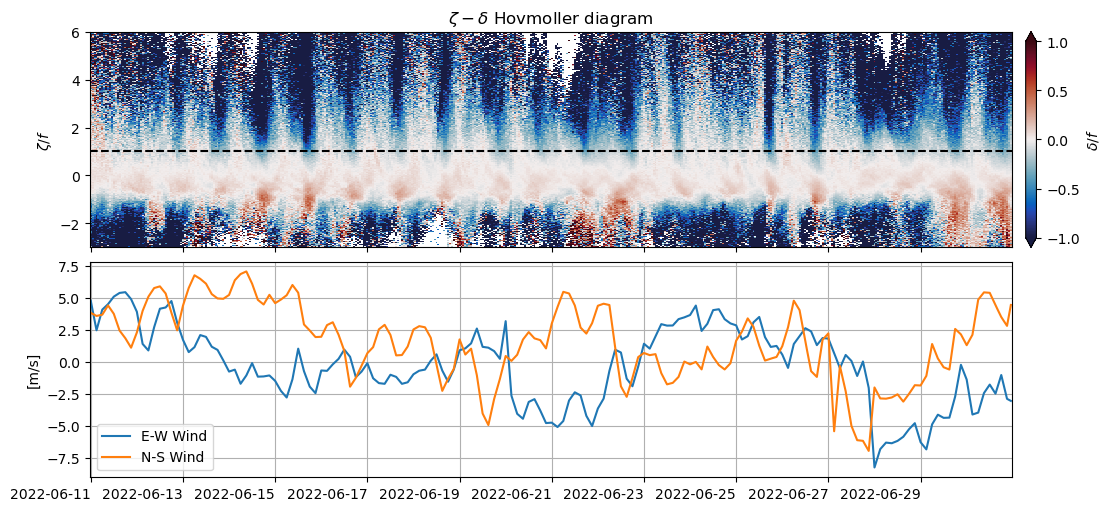

In [17]:
fig, ax = plt.subplots(2, figsize = (11,5), sharex = True, constrained_layout = True)

# t1 = rvort_weighted/(rvort_weighted.max())
c = zd_weighted.plot(x = 'ocean_time', ax = ax[0], cmap = cmo.balance, vmin = -1, vmax = 1, add_colorbar = False)
fig.colorbar(c, ax = ax[0], pad = 0.015,
             label = r'$\delta/f$', 
             extend = 'both')
ax[0].set_xlabel('')
ax[0].set_ylim(-3,6)
ax[0].set_ylabel('$\zeta/f$')
ax[0].axhline(1, c = 'k',ls = '--')
# ax[0].set_xlim('2022-06-24', '2022-07-01')
ax[0].set_title('$\zeta - \delta$ Hovmoller diagram')

tx.plot(ax = ax[1], label = r'E-W Wind')
ty.plot(ax = ax[1], label = r'N-S Wind')
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('[m/s]')
ax[1].set_xlabel('')
plt.xticks(rotation=0)

# plt.savefig('omega_hov_1.jpg', dpi =300)

## Query the limits to match Lixin's figure 

(array([19154., 19156., 19158., 19160., 19162., 19164., 19166., 19168.,
        19170., 19172.]),
 [Text(19154.0, 0, '2022-06-11'),
  Text(19156.0, 0, '2022-06-13'),
  Text(19158.0, 0, '2022-06-15'),
  Text(19160.0, 0, '2022-06-17'),
  Text(19162.0, 0, '2022-06-19'),
  Text(19164.0, 0, '2022-06-21'),
  Text(19166.0, 0, '2022-06-23'),
  Text(19168.0, 0, '2022-06-25'),
  Text(19170.0, 0, '2022-06-27'),
  Text(19172.0, 0, '2022-06-29')])

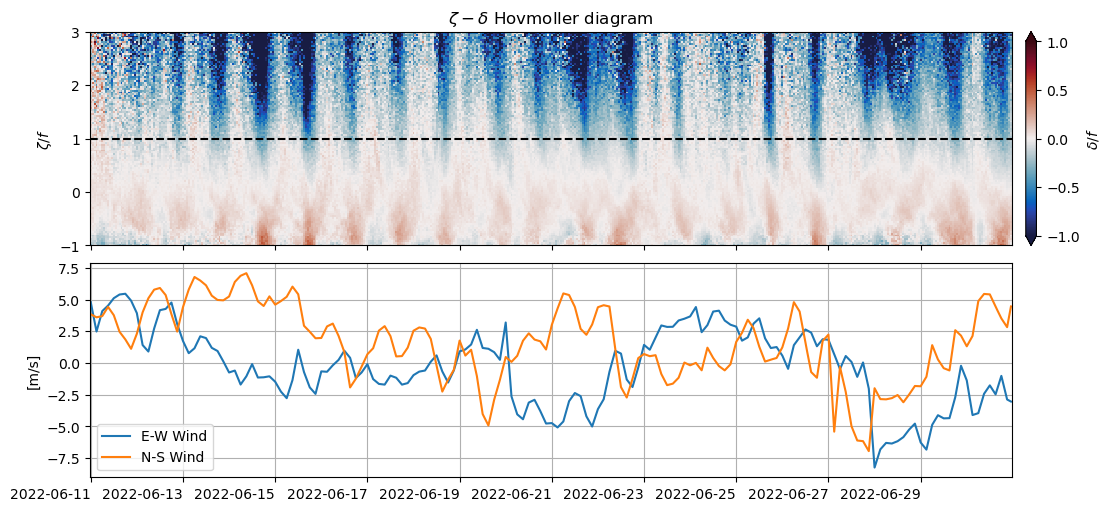

In [18]:
fig, ax = plt.subplots(2, figsize = (11,5), sharex = True, constrained_layout = True)

c = zd_weighted.plot(x = 'ocean_time', ax = ax[0], cmap = cmo.balance, vmin = -1, vmax = 1, add_colorbar = False)
fig.colorbar(c, ax = ax[0], pad = 0.015,
             label = r'$\delta/f$', 
             extend = 'both')
ax[0].set_xlabel('')
ax[0].set_ylim(-1,3)
ax[0].set_ylabel('$\zeta/f$')
ax[0].axhline(1, c = 'k',ls = '--')
ax[0].set_title('$\zeta - \delta$ Hovmoller diagram')

tx.plot(ax = ax[1], label = r'E-W Wind')
ty.plot(ax = ax[1], label = r'N-S Wind')
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('[m/s]')
ax[1].set_xlabel('')
plt.xticks(rotation=0)

## Conclusion: We don't have to look very hard to find this process, it seems ubiqitous this time of year. 